In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib

from tensorflow_decision_forests.keras.keras_test import train_test_split
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT" # replace with your path

In [2]:
def load_data(path_to_data):
    images_temp = []
    labels_temp = []
    verified_subfolders = []
    subfolders = os.listdir(path_to_data)
    for subfolder in subfolders:
        if os.path.isdir(os.path.join(path_to_data, subfolder)):
            verified_subfolders.append(subfolder)
    print(verified_subfolders)
    for folder in verified_subfolders:
        for img in os.listdir(os.path.join(path_to_data, folder)):
            label = str(img)[:str(img).index('_')]
            image = load_img(os.path.join(path_to_data, folder,img), target_size=(64, 64))
            img_array = img_to_array(image)
            images_temp.append(img_array)
            labels_temp.append(label)
    images_np = np.array(images_temp)
    labels_np = np.array(labels_temp)

    return images_np, labels_np

In [3]:
images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']
Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


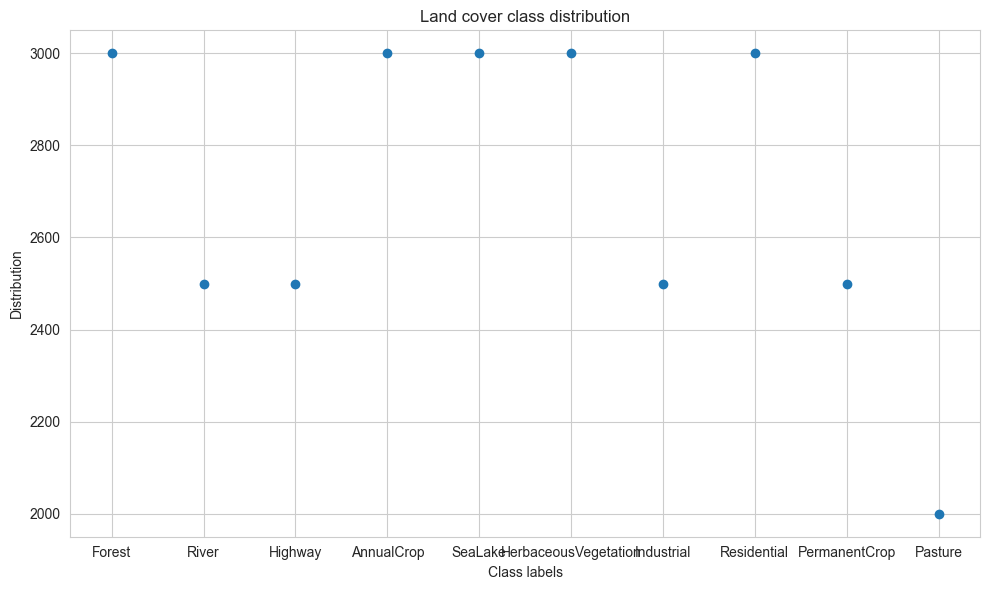

In [4]:
# EDA 
label_count = {}
for label in labels:
    matching_label = labels[labels == label][0]
    
    if matching_label not in label_count:
        label_count[matching_label] = label_count.get(matching_label,0) + 1
    else:
        label_count[matching_label] +=1
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))
plt.scatter(label_count.keys(),label_count.values())
ax1.set_title('Land cover class distribution')
ax1.set_xlabel('Class labels')
ax1.set_ylabel('Distribution')
plt.tight_layout()
plt.show()

In [5]:
# Encode labels 
encoder = LabelEncoder().fit(list(set(labels)))
encoded_labels = encoder.transform(labels) 
encoded_labels_classes = list(encoder.classes_)

In [6]:
def split_data(images, labels, split):
    
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    indices = np.arange(images.shape[0])
    shuffled_indices = np.random.permutation(indices)
    images_shuffled = images[shuffled_indices]
    labels_shuffled = labels[shuffled_indices]
    
    # create data splits
    splits = np.multiply(len(labels_shuffled), split).astype(int)
    X_train, X_val, X_test = np.split(images_shuffled, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(labels_shuffled, [splits[0], splits[0]+splits[1]])
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
# define splits
split = (0.6, 0.2, 0.2)
# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


In [8]:
def data_preprocessing(X, y, data_partition='train'):
    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        X_augm = tf.image.adjust_brightness(X, DELTA)
        X_augm = tf.image.adjust_contrast(X_augm, CONTRAST_FACTOR)
        X_augm = tf.image.random_flip_left_right(X_augm)
        X = tf.concat([X, X_augm], axis=0)        
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() 
        y = tf.gather(y, shuffle).numpy() 
    X = X/255.0

    return X, y

In [9]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


In [10]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


Train, prediction accuracy: 0.47617283950617284
Validation, prediction accuracy: 0.4414814814814815


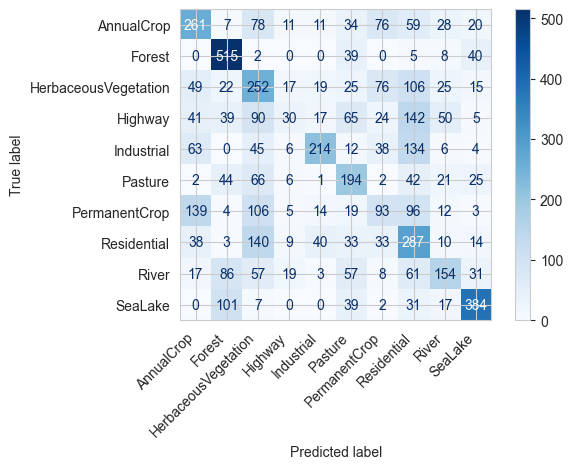

In [11]:
# Baseline model
from sklearn.ensemble import RandomForestClassifier
rf_clf1 = RandomForestClassifier(n_estimators=2, n_jobs=1,max_depth=8, random_state=7)
fitted_model = rf_clf1.fit(X_train_re, y_train)
training_data_model_prediction = fitted_model.predict(X_train_re)

training_accuracy = accuracy_score(y_train, training_data_model_prediction)
print(f'Train, prediction accuracy: {training_accuracy}')

validation_data_model_prediction = fitted_model.predict(X_val_re)
val_accuracy = accuracy_score(y_val, validation_data_model_prediction)
print(f'Validation, prediction accuracy: {val_accuracy}')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
decoded_labels = encoder.inverse_transform(y_val)  # optional if y_val is already original labels
decoded_predictions = encoder.inverse_transform(validation_data_model_prediction)

conf_matrix = confusion_matrix(decoded_labels,decoded_predictions,labels=np.unique(decoded_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=np.unique(decoded_labels))
disp.plot(cmap='Blues')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

In [12]:
#Improved model
rf_clf2 = RandomForestClassifier(
    n_estimators=200,
    n_jobs=4,
    random_state=7,
    max_depth=8,
    max_features=795,
    min_samples_split=64,
    min_samples_leaf=32,
    class_weight='balanced',
    verbose=1
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
Python(66498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 10.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 10.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


Train, prediction accuracy: 0.6316358024691358


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


Validation, prediction accuracy: 0.5642592592592592


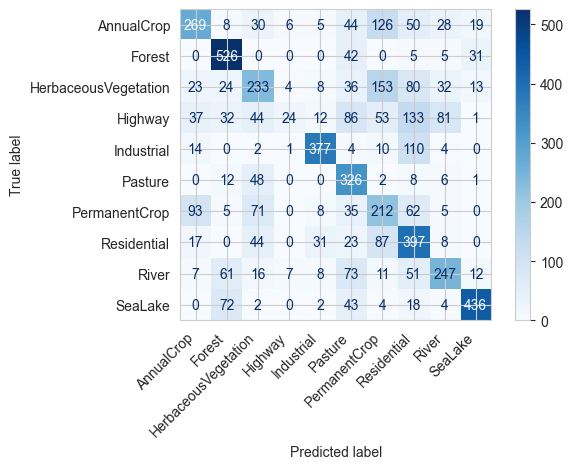

In [13]:
model = rf_clf2.fit(X_train_re,y_train)
training_data_model_prediction = rf_clf2.predict(X_train_re)
training_accuracy = accuracy_score(y_train, training_data_model_prediction)
print(f'Train, prediction accuracy: {training_accuracy}')

validation_data_model_prediction = rf_clf2.predict(X_val_re)
val_accuracy = accuracy_score(y_val, validation_data_model_prediction)
print(f'Validation, prediction accuracy: {val_accuracy}')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
decoded_labels = encoder.inverse_transform(y_val)  # optional if y_val is already original labels
decoded_predictions = encoder.inverse_transform(validation_data_model_prediction)

conf_matrix = confusion_matrix(decoded_labels,decoded_predictions,labels=np.unique(decoded_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=np.unique(decoded_labels))
disp.plot(cmap='Blues')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

In [14]:
testing_data_model_prediction = rf_clf2.predict(X_test_re)
test_accuracy = accuracy_score(y_test, testing_data_model_prediction)
print(f'Test, prediction accuracy: {test_accuracy}')

Test, prediction accuracy: 0.5618518518518518


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
